## From Training to Deployment with Tensorflow and OpenVINO 

This example demonstrates how to train, convert, and deploy an image classification model with Tensorflow and OpenVINO. This particular notebook shows the second half the process where we perform the inference step. 

The training code is based on the official Tensorflow Image Classification Tutorial (https://www.tensorflow.org/tutorials/images/classification).

Then, the code has been adopted and modified to showcase the use of OpenVINO model optimizer and generates a new OpenVINO IR on-demand.  
https://colab.research.google.com/drive/1oNxfvx5jOfcmk1Nx0qavjLN8KtWcLRn6?usp=sharing

The **flower.bin** and **flower.xml** can be obtained by executing the COLAB code with 'Runtime->Run All' or the Ctrl+F9 command. A zip files 


In [13]:
import os
import subprocess
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf

In [14]:
#install pre-req
#!pip install pillow numpy -q
from PIL import Image
import numpy as np

def pre_process_image(imagePath, img_height=180):
    # Model input format
    n, c, h, w = [1, 3, img_height, img_height]
    image = Image.open(imagePath)
    image = image.resize((h, w), resample=Image.BILINEAR)

    # Normalize to keep data between 0 - 1
    image = np.array(image) 

    # Change data layout from HWC to CHW
    image = image.transpose((2, 0, 1))
    input_image = image.reshape((n, c, h, w))

    return input_image

This image most likely belongs to dandelion with a 96.77 percent confidence.


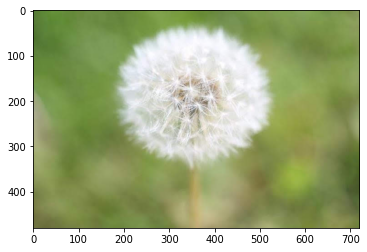

In [15]:
from openvino.inference_engine import IECore
class_names=['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

model_xml = f'flower.xml'
model_bin = f'flower.bin'

# Load network to the plugin
ie = IECore()
net = ie.read_network(model=model_xml, weights=model_bin)

#Neural Compute Stick
#exec_net = ie.load_network(network=net, device_name="MYRIAD")
exec_net = ie.load_network(network=net, device_name="CPU")

del net

input_layer = next(iter(exec_net.input_info))
output_layer = next(iter(exec_net.outputs))

# Run the Inference on the Input image...
inp_img_url = "https://upload.wikimedia.org/wikipedia/commons/4/48/A_Close_Up_Photo_of_a_Dandelion.jpg"
inp_file_name = 'A_Close_Up_Photo_of_a_Dandelion.jpg'

#Download the image from the storage
output = subprocess.check_output(f"curl {inp_img_url} --output {inp_file_name}", shell=True)

#Pre-process the image and get it ready for inference.
input_image = pre_process_image(inp_file_name)

res = exec_net.infer(inputs={input_layer: input_image})
res = res[output_layer]

score = tf.nn.softmax(res[0])

#show the results
image = Image.open(inp_file_name)
plt.imshow(image)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)